In [1]:
import datetime as dt, numpy as np, pandas as pd, os, matplotlib.pyplot as plt, seaborn as sns
from util import get_data, plot_data

In [2]:
original_directory = os.getcwd()

In [3]:
def symbol_to_path(symbol, base_dir=None):
    """Return CSV file path given ticker symbol."""
    if base_dir is None:
        base_dir = os.environ.get("MARKET_DATA_DIR", "data/")
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))

In [4]:
def get_data(symbols, dates, addSPY=True, colname="Adj Close"):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col="Date", parse_dates=True, usecols=["Date", colname],
                              na_values=["nan"])
        df_temp = df_temp.rename(columns={colname: symbol})
        df = df.join(df_temp)

    df = df.reset_index()
    df = df.rename(columns={'index': 'Date'})
    df.dropna(inplace=True)
    return df

In [5]:
def compute_portvals(orders_file="orders/orders.csv", start_val=1000000, commission=9.95, impact=0.005):

    multiple = pd.read_csv(orders_file)
    updated = multiple.sort_values(by=['Date']).copy()
    updated['Stocks Owned'] = [{i: 0.0 for i in list(multiple['Symbol'].unique())} for x in range(len(updated.index))]
    updated.sort_values(by=['Date'])
    updated = updated.reset_index()
    del updated['index']
    start_date = updated['Date'].iloc[0]
    end_date = updated['Date'].iloc[-1]
    dates = pd.date_range(start_date, end_date)
    symbols = list(multiple['Symbol'].unique())
    stocks_traded = symbols.copy()
    symbols.append('$SPX')
    stocks = get_data(symbols, dates)
    for d in range(0, len(updated)):
        updated.loc[d, 'Stock_Price'] = float(stocks[stocks['Date'] == updated.iloc[d][0]][updated.iloc[d][1]])
        if updated['Order'][d] == "BUY":
            for i in range(d, len(updated)):
                updated['Stocks Owned'][i][updated['Symbol'][d]] += float(updated['Shares'][d])
        if updated['Order'][d] == "SELL":
            for i in range(d, len(updated)):
                updated['Stocks Owned'][i][updated['Symbol'][d]] -= float(updated['Shares'][d])

    updated['Stock Val'] = updated['Shares'] * updated['Stock_Price']
    updated['impct & cmsn'] = -1.00 * ((updated['Stock Val'] * impact) + commission)

    updated.loc[updated['Order'] == 'BUY', 'Stock Val'] *= -1
    updated_list = updated[['Date', 'Symbol', 'Stock Val', 'impct & cmsn', 'Order']].values.tolist()

    cash = start_val
    for i, j, k, l, m in updated_list:
        cash += (k + l)
        updated.loc[(updated["Date"] == i) & (updated["Symbol"] == j) & (updated["Order"] == m), 'cash'] = float(cash)

    Date = []
    spx = stocks[['Date', '$SPX']]
    for i in pd.date_range(start_date, end_date):
        if i in list(spx['Date']):
            Date.append(i)

    Final = pd.DataFrame(Date, columns=['Date'])
    Final.Date = pd.to_datetime(Final.Date)
    updated.Date = pd.to_datetime(updated.Date)
    Final = Final.merge(updated, how='left')
    Final['Stocks Owned'].fillna(method='ffill', inplace=True)
    Final['cash'].fillna(method='ffill', inplace=True)

    updated = Final

    portfolio = []
    updated_list = updated[['Date', 'Stocks Owned', 'cash']].values.tolist()

    Stocks_to_Cash = []
    for i in range(len(updated)):
        s_2_c = 0.0
        for j in updated.iloc[i]['Stocks Owned']:
            adj_close = float(stocks[stocks['Date'] == updated.iloc[i]['Date']][j])
            s_2_c += updated.iloc[i]['Stocks Owned'][j] * adj_close
        Stocks_to_Cash.append(s_2_c)

    updated["Stocks_to_Cash"] = Stocks_to_Cash
    updated['Portfolio'] = updated["Stocks_to_Cash"] + updated["cash"]
    portvals = updated.copy()
    portvals = portvals.set_index('Date')
    portvals = portvals[~portvals.index.duplicated(keep='last')]
    portvals = portvals['Portfolio']


    return pd.DataFrame(portvals), stocks_traded, start_date, end_date

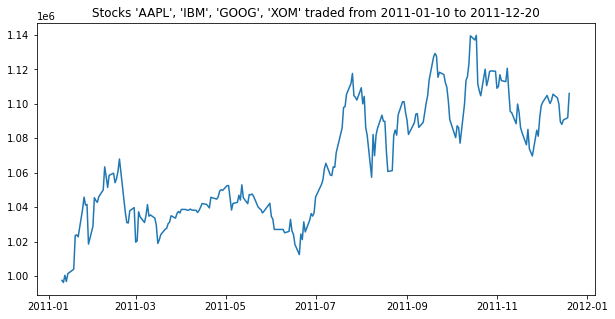

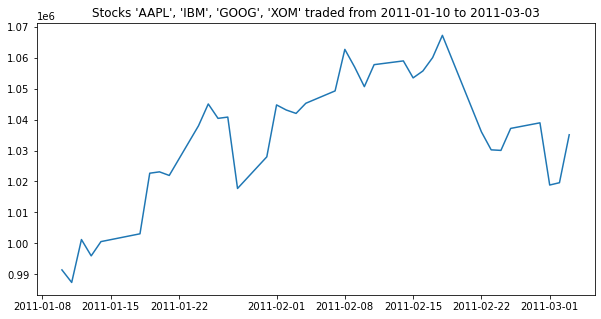

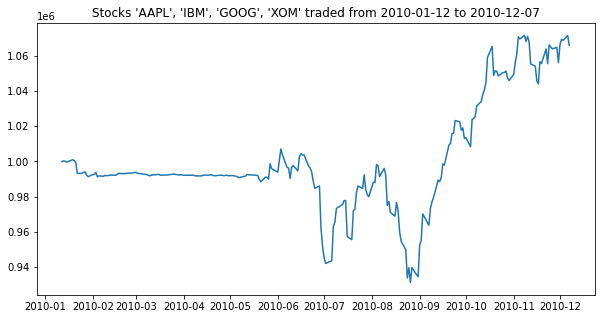

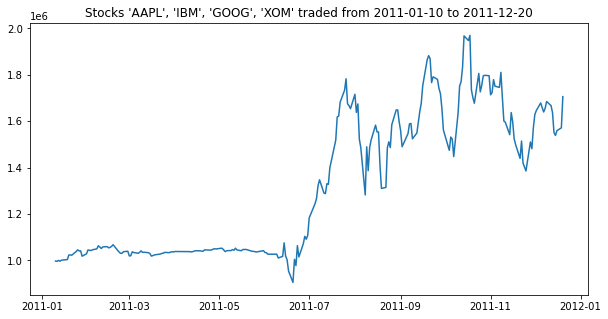

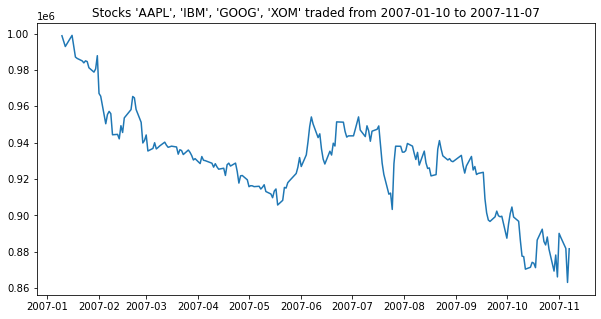

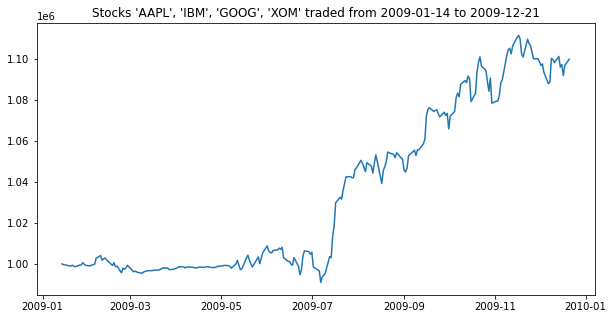

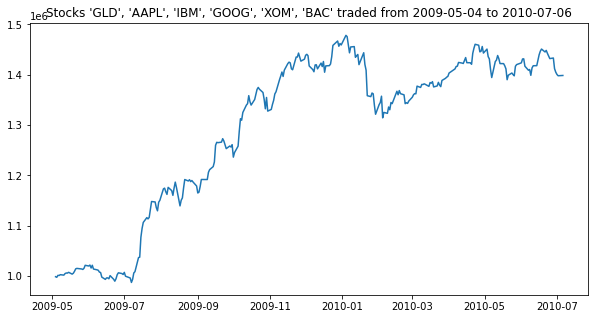

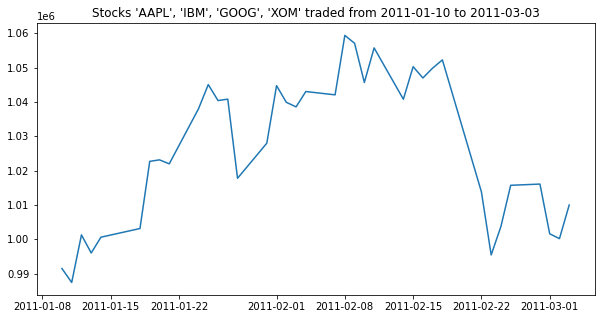

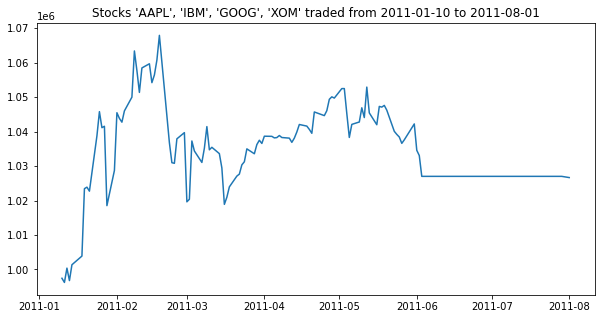

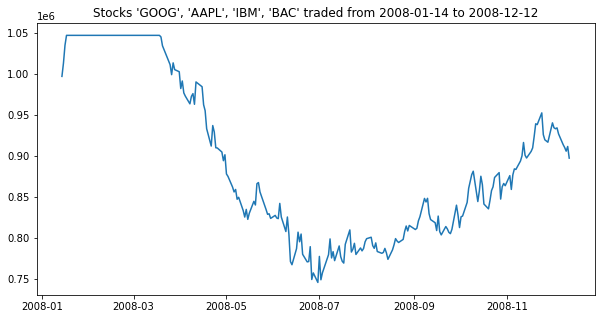

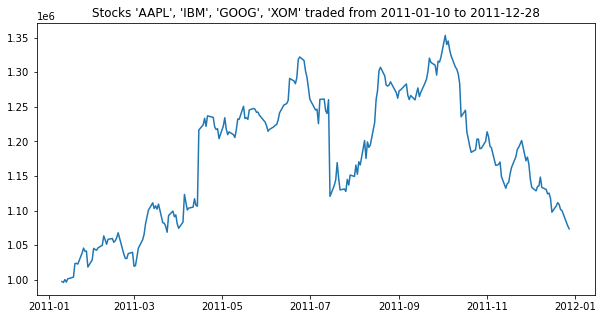

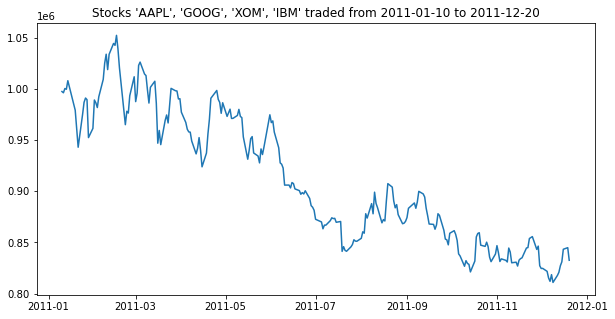

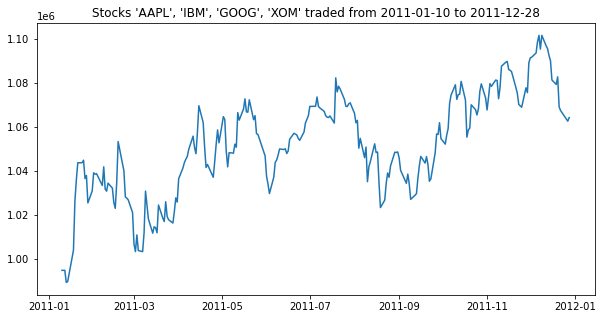

In [6]:
for i in os.listdir('./orders'):
    portfolio, stocks_traded, start_date, end_date = compute_portvals(orders_file="orders/{}".format(i), start_val=1000000, commission=9.95, impact=0.005)
    fig, ax = plt.subplots(figsize = (10,5))
    plt.title("Stocks {} traded from {} to {}".format(", ".join( repr(e) for e in stocks_traded), start_date, end_date))
    plt.plot(portfolio)
    plt.show() 
